# Implementation of ResNet-50 for Market-1501

In [ ]:
import os
import torch
import yaml
import sys
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [7]:
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
sys.path.append(os.getcwd())

In [49]:
from src.dataloaders.market_dataset import MarketDataset
from src.models.resnet50 import ResNet50
from src.utils.losses import TripletLoss
from src.utils.trainer import train_one_epoch, train_model
from src.utils.evaluator import extract_features, evaluate
from src.utils.visualizer import visualize_results

ImportError: cannot import name 'train_model' from 'src.utils.trainer' (c:\Users\clemm\Documents\CentraleSupelec\IA\DeepLearning\Projet\Person-Re-Identification\src\utils\trainer.py)

In [36]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)["reid_project"]

In [10]:
# Define transforms: We use Bicubic interpolation as it preserves identity details better
transform_test = transforms.Compose([
    transforms.Resize(config['market1501']['img_size'], 
                      interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
dataset = MarketDataset(
    root_dir=config['market1501']['root_dir'], 
    subset='train', 
    transform=transform_test
)

In [12]:
# Use the batch size defined in your yaml under the resnet50 section
m_cfg = config['models']['resnet50']
loader = DataLoader(dataset, batch_size=m_cfg['train']['batch_size'], shuffle=True)


In [14]:
model = ResNet50(
    num_classes=config['market1501']['num_classes'], 
    feature_dim=m_cfg['feature_dim'],
    last_stride=m_cfg['last_stride']
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\clemm/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 29.1MB/s]


In [15]:
model.eval()
images, labels = next(iter(loader))

In [16]:
with torch.no_grad():
    features = model(images)

In [17]:
print(f"Success!")
print(f"Input batch shape: {images.shape}")
print(f"Output feature shape: {features.shape}")

Success!
Input batch shape: torch.Size([32, 3, 256, 128])
Output feature shape: torch.Size([32, 2048])


In [20]:
def imshow_batch(input_tensor, title=None):
    """Denormalize and display a batch of images."""
    # Convert tensor to numpy and change dim order: [C, H, W] -> [H, W, C]
    input_tensor = input_tensor.numpy().transpose((1, 2, 0))
    
    # Denormalize (ImageNet stats)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_tensor = std * input_tensor + mean
    input_tensor = np.clip(input_tensor, 0, 1)
    
    plt.imshow(input_tensor)
    if title:
        plt.title(title)
    plt.axis('off')

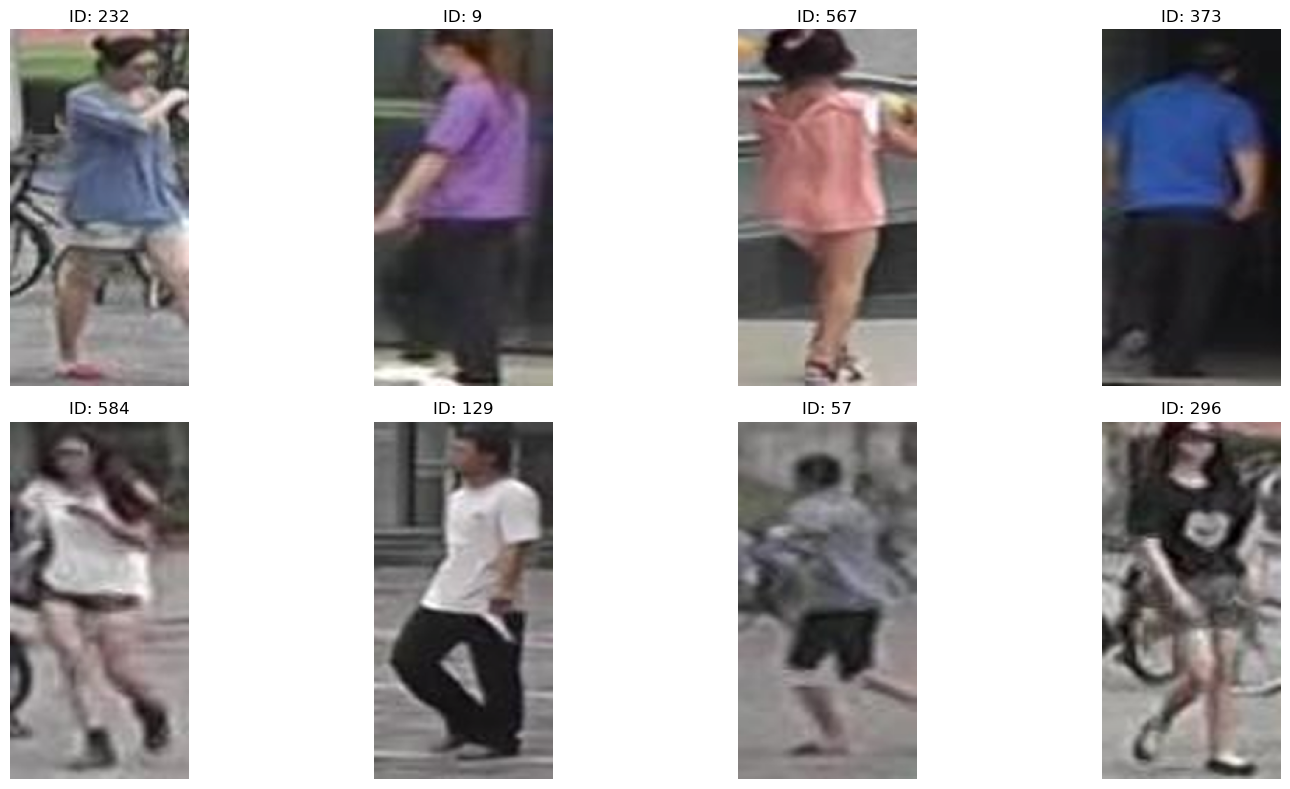

In [21]:
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow_batch(images[i], title=f"ID: {labels[i].item()}")
plt.tight_layout()
plt.show()

In [41]:
device = torch.device(config['general']['device'])
model = model.to(device)

In [42]:
m_cfg = config['models']['resnet50']
criterion_xent = torch.nn.CrossEntropyLoss()
criterion_triplet = TripletLoss(margin=m_cfg['loss']['margin'])

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=m_cfg['train']['learning_rate'])

In [44]:
print(f"Starting training on {device}...")
epoch_loss = train_one_epoch(
    model, loader, optimizer, 
    criterion_xent, criterion_triplet, 
    device, m_cfg['loss']
)

Starting training on cpu...


Training: 100%|██████████| 405/405 [30:37<00:00,  4.54s/it, loss=2.79]


In [50]:
from src.utils.logging import save_checkpoint

In [54]:
save_checkpoint(
        model=model, 
        epoch=1, 
        output_dir=config['general']['output_dir']
    )

Model Saved : results/exp_resnet50_v1\resnet50_reid_epoch_1.pth


Evaluation after one epoch on the test set:

In [ ]:
query_ds = MarketDataset(root_dir=config['market1501']['root_dir'], subset='query', transform=transform_test)
gallery_ds = MarketDataset(root_dir=config['market1501']['root_dir'], subset='test', transform=transform_test)

query_loader = DataLoader(query_ds, batch_size=32, shuffle=False)
gallery_loader = DataLoader(gallery_ds, batch_size=32, shuffle=False)

In [ ]:
print("Extraction of Query features...")
q_f, q_p = extract_features(model, query_loader, device)
print("Extraction of Gallery features...")
g_f, g_p = extract_features(model, gallery_loader, device)

In [ ]:
r1, mAP, distmat = evaluate(q_f, q_p, g_f, g_p)
print("Results after epoch 1:")
print(f"Rank-1 Accuracy: {r1*100:.2f}%")
print(f"mAP: {mAP*100:.2f}%")

In [ ]:
visualize_results(query_ds, gallery_ds, distmat, top_k=5)

Training on more than one epoch:

In [ ]:
scheduler = CosineAnnealingLR(optimizer, T_max=config['market1501']['train']['epochs'])

In [ ]:
train_model(
    model=model,
    train_loader=loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion_xent=criterion_xent,
    criterion_triplet=criterion_triplet,
    device=device,
    config=m_cfg['loss'],
    num_epochs=config['market1501']['train']['epochs'],
    output_dir=config['general']['output_dir']
)